In [2]:
import sys
print(sys.executable)


c:\Users\adhik\OneDrive\Desktop\job_recommendation_system\venv\Scripts\python.exe


In [3]:
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import load_npz
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


In [4]:
df = pd.read_csv("../backend/models/jobs_with_features.csv")
print("Jobs:", df.shape)


Jobs: (986, 18)


In [5]:
tfidf = pickle.load(open("../backend/models/tfidf_vectorizer.pkl", "rb"))
X_tfidf = load_npz("../backend/models/tfidf_matrix.npz")

print("TF-IDF matrix:", X_tfidf.shape)


TF-IDF matrix: (986, 7000)


In [6]:
bm25 = pickle.load(open("../backend/models/bm25_model.pkl", "rb"))
print("BM25 loaded")


BM25 loaded


In [7]:
model_name = open("../backend/models/sbert_model_name.txt").read().strip()
model = SentenceTransformer(model_name)

job_embeddings = np.load("../backend/models/sbert_job_embeddings.npy")
print("SBERT embeddings:", job_embeddings.shape)


SBERT embeddings: (986, 384)


In [8]:
test_queries = [
    "frontend developer react internship",
    "data analyst python sql",
    "customer service work from home"
]


In [9]:
def eval_tfidf(query, top_n=5):
    q_vec = tfidf.transform([query])
    sims = cosine_similarity(q_vec, X_tfidf).flatten()
    df_out = df.copy()
    df_out["score"] = sims
    return df_out.sort_values("score", ascending=False).head(top_n)[
        ["job_title", "location", "job_type", "score"]
    ]


In [10]:
def eval_bm25(query, top_n=5):
    tokens = query.lower().split()
    scores = bm25.get_scores(tokens)
    df_out = df.copy()
    df_out["score"] = scores
    return df_out.sort_values("score", ascending=False).head(top_n)[
        ["job_title", "location", "job_type", "score"]
    ]


In [11]:
def eval_sbert(query, top_n=5):
    q_emb = model.encode([query], normalize_embeddings=True)[0]
    sims = job_embeddings @ q_emb
    df_out = df.copy()
    df_out["score"] = sims
    return df_out.sort_values("score", ascending=False).head(top_n)[
        ["job_title", "location", "job_type", "score"]
    ]


In [12]:
query = test_queries[0]

print("TF-IDF")
display(eval_tfidf(query))

print("BM25")
display(eval_bm25(query))

print("SBERT")
display(eval_sbert(query))


TF-IDF


,job_title,location,job_type,score
585,Java Developer Level 2,"Cincinnati, OH 45202",Contract,0.336049
484,"Principal Product Manager, Technical, AWS Deve...","San Francisco, CA",Full-time,0.236713
507,"Senior Product Manager, Technical, AWS Develop...","San Francisco, CA",Full-time,0.225627
265,Senior Applications Developer,"Omaha, NE 68137",Full-time,0.122074
150,Quantitative Analyst/Developer,"New York, NY",Full-time,0.108838


BM25


,job_title,location,job_type,score
585,Java Developer Level 2,"Cincinnati, OH 45202",Contract,13.682177
356,Lead Fullstack Engineer / Java / React / WFH F...,"Lake Forest, IL 60045",Full-time,10.830277
487,Senior Technical Product Manager - Cloud Infra...,"San Francisco, CA 94111",Full-time,7.767723
484,"Principal Product Manager, Technical, AWS Deve...","San Francisco, CA",Full-time,7.579444
507,"Senior Product Manager, Technical, AWS Develop...","San Francisco, CA",Full-time,7.477968


SBERT


,job_title,location,job_type,score
356,Lead Fullstack Engineer / Java / React / WFH F...,"Lake Forest, IL 60045",Full-time,0.533790
428,Risk Engineering Training Program - Colorado -...,"Denver, CO",Full-time,0.343808
969,"Sr Manager, Product Management","South San Francisco, CA 94080",Full-time,0.323684
470,AI Training for Mathematics,Remote,"Contract, Freelance",0.315797
265,Senior Applications Developer,"Omaha, NE 68137",Full-time,0.313184


In [13]:
np.random.seed(42)
df["cf_score"] = np.random.uniform(0.3, 0.7, size=len(df))


In [14]:
def recommend_hybrid(
    profile_text,
    top_n=10,
    alpha=0.8,   # content weight
    location=None,
    job_type=None
):
    q_emb = model.encode([profile_text], normalize_embeddings=True)[0]
    content_scores = job_embeddings @ q_emb

    results = df.copy()
    results["content_score"] = content_scores
    results["final_score"] = alpha * results["content_score"] + (1 - alpha) * results["cf_score"]

    if location and location.lower() != "any":
        results = results[results["location"].str.contains(location, case=False, na=False)]

    if job_type and job_type.lower() != "any":
        results = results[results["job_type"].str.contains(job_type, case=False, na=False)]

    results = results.sort_values("final_score", ascending=False).head(top_n)

    return results[
        ["job_title", "company_name", "location", "job_type", "final_score"]
    ]


In [15]:
recommend_hybrid("frontend developer react internship", top_n=5)


,job_title,company_name,location,job_type,final_score
356,Lead Fullstack Engineer / Java / React / WFH F...,Motion Recruitment,"Lake Forest, IL 60045",Full-time,0.489153
408,"Senior Software Developer PHP - Remote (CA, WA...",Providence Health Plan,"Salem, OR 97302",Full-time,0.378465
270,JUNIOR GRAPHIC DESIGNER,Cella,Remote,Contract,0.375062
265,Senior Applications Developer,Buildertrend,"Omaha, NE 68137",Full-time,0.369809
428,Risk Engineering Training Program - Colorado -...,Zurich Insurance Company Ltd.,"Denver, CO",Full-time,0.363120


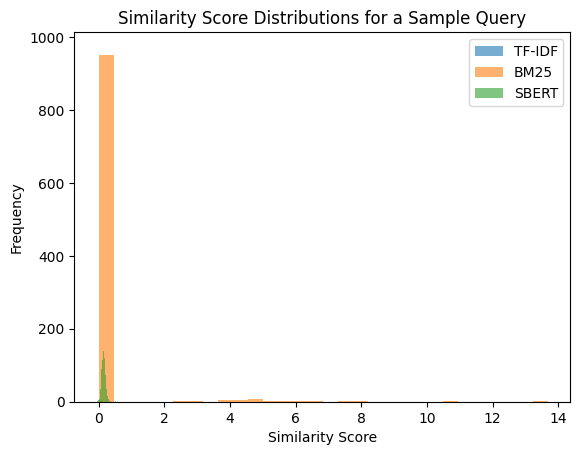

In [16]:
import matplotlib.pyplot as plt

query = "frontend developer react internship"

# TF-IDF scores
q_vec = tfidf.transform([query])
tfidf_scores = cosine_similarity(q_vec, X_tfidf).flatten()

# BM25 scores
bm25_scores = bm25.get_scores(query.lower().split())

# SBERT scores
q_emb = model.encode([query], normalize_embeddings=True)[0]
sbert_scores = job_embeddings @ q_emb

plt.figure()
plt.hist(tfidf_scores, bins=30, alpha=0.6, label="TF-IDF")
plt.hist(bm25_scores, bins=30, alpha=0.6, label="BM25")
plt.hist(sbert_scores, bins=30, alpha=0.6, label="SBERT")
plt.legend()
plt.title("Similarity Score Distributions for a Sample Query")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()


In [17]:
def top_titles(df_out):
    return set(df_out["job_title"].tolist())

query = "data analyst python sql"

tfidf_top = top_titles(eval_tfidf(query))
bm25_top = top_titles(eval_bm25(query))
sbert_top = top_titles(eval_sbert(query))

overlap = {
    "TF-IDF ∩ BM25": len(tfidf_top & bm25_top),
    "TF-IDF ∩ SBERT": len(tfidf_top & sbert_top),
    "BM25 ∩ SBERT": len(bm25_top & sbert_top),
}

overlap


{'TF-IDF ∩ BM25': 1, 'TF-IDF ∩ SBERT': 2, 'BM25 ∩ SBERT': 3}

In [18]:
alphas = [0.2, 0.4, 0.6, 0.8]
top_titles_by_alpha = {}

for a in alphas:
    recs = recommend_hybrid(
        "frontend developer react internship",
        top_n=5,
        alpha=a
    )
    top_titles_by_alpha[a] = recs["job_title"].tolist()

top_titles_by_alpha


{0.2: ['Consultant/Accountant',
  'Institutional Equity Research Sales Analyst / Associate',
  'Bilingual Content Writer & Editor Specialist German-English Fluency Required (Freelance)',
  'Program Manager - Product Counsel',
  'Tax Senior'],
 0.4: ['Senior Software Developer PHP - Remote (CA, WA or OR Only)',
  'Consultant/Accountant',
  'Senior Manager, Leisure (Remote)',
  'Campus Recruiting and Program Management - Sr Analyst - C12 - NEW YORK',
  'Inbound Contacts Representative'],
 0.6: ['Senior Software Developer PHP - Remote (CA, WA or OR Only)',
  'Lead Fullstack Engineer / Java / React / WFH Flexibility / Great Employee Retention',
  'JUNIOR GRAPHIC DESIGNER',
  'Consultant/Accountant',
  'Senior Product Manager, Technical, AWS Developer Experience'],
 0.8: ['Lead Fullstack Engineer / Java / React / WFH Flexibility / Great Employee Retention',
  'Senior Software Developer PHP - Remote (CA, WA or OR Only)',
  'JUNIOR GRAPHIC DESIGNER',
  'Senior Applications Developer',
  'Risk

In [19]:
query = "frontend developer react internship"

print("SBERT only")
display(eval_sbert(query))

print("Hybrid (alpha = 0.8)")
display(recommend_hybrid(query, alpha=0.8))


SBERT only


,job_title,location,job_type,score
356,Lead Fullstack Engineer / Java / React / WFH F...,"Lake Forest, IL 60045",Full-time,0.533790
428,Risk Engineering Training Program - Colorado -...,"Denver, CO",Full-time,0.343808
969,"Sr Manager, Product Management","South San Francisco, CA 94080",Full-time,0.323684
470,AI Training for Mathematics,Remote,"Contract, Freelance",0.315797
265,Senior Applications Developer,"Omaha, NE 68137",Full-time,0.313184


Hybrid (alpha = 0.8)


,job_title,company_name,location,job_type,final_score
356,Lead Fullstack Engineer / Java / React / WFH F...,Motion Recruitment,"Lake Forest, IL 60045",Full-time,0.489153
408,"Senior Software Developer PHP - Remote (CA, WA...",Providence Health Plan,"Salem, OR 97302",Full-time,0.378465
270,JUNIOR GRAPHIC DESIGNER,Cella,Remote,Contract,0.375062
265,Senior Applications Developer,Buildertrend,"Omaha, NE 68137",Full-time,0.369809
428,Risk Engineering Training Program - Colorado -...,Zurich Insurance Company Ltd.,"Denver, CO",Full-time,0.363120
507,"Senior Product Manager, Technical, AWS Develop...","Amazon Web Services, Inc.","San Francisco, CA",Full-time,0.359707
969,"Sr Manager, Product Management",Thermo Fisher Scientific,"South San Francisco, CA 94080",Full-time,0.357032
661,Consultant/Accountant,Miaplaza Inc.,Remote,Contract,0.344209
444,EXPERIENTIAL DESIGNER,Cella,Remote,Contract,0.342367
412,"Senior Manager, Leisure (Remote)",American Express Global Business Travel,California,Full-time,0.340143


In [20]:
query = "frontend developer react internship"

sbert_only = eval_sbert(query, top_n=5).reset_index(drop=True)
sbert_only["Rank_SBERT"] = sbert_only.index + 1

sbert_only


,job_title,location,job_type,score,Rank_SBERT
0,Lead Fullstack Engineer / Java / React / WFH F...,"Lake Forest, IL 60045",Full-time,0.533790,1
1,Risk Engineering Training Program - Colorado -...,"Denver, CO",Full-time,0.343808,2
2,"Sr Manager, Product Management","South San Francisco, CA 94080",Full-time,0.323684,3
3,AI Training for Mathematics,Remote,"Contract, Freelance",0.315797,4
4,Senior Applications Developer,"Omaha, NE 68137",Full-time,0.313184,5


In [21]:
hybrid_only = recommend_hybrid(
    query,
    top_n=5,
    alpha=0.8
).reset_index(drop=True)

hybrid_only["Rank_Hybrid"] = hybrid_only.index + 1

hybrid_only


,job_title,company_name,location,job_type,final_score,Rank_Hybrid
0,Lead Fullstack Engineer / Java / React / WFH F...,Motion Recruitment,"Lake Forest, IL 60045",Full-time,0.489153,1
1,"Senior Software Developer PHP - Remote (CA, WA...",Providence Health Plan,"Salem, OR 97302",Full-time,0.378465,2
2,JUNIOR GRAPHIC DESIGNER,Cella,Remote,Contract,0.375062,3
3,Senior Applications Developer,Buildertrend,"Omaha, NE 68137",Full-time,0.369809,4
4,Risk Engineering Training Program - Colorado -...,Zurich Insurance Company Ltd.,"Denver, CO",Full-time,0.363120,5


In [22]:
comparison = pd.merge(
    sbert_only,
    hybrid_only,
    on="job_title",
    how="outer",
    suffixes=("_SBERT", "_Hybrid")
)

comparison[
    ["job_title", "Rank_SBERT", "Rank_Hybrid"]
]


,job_title,Rank_SBERT,Rank_Hybrid
0,AI Training for Mathematics,4.0,NaN
1,JUNIOR GRAPHIC DESIGNER,NaN,3.0
2,Lead Fullstack Engineer / Java / React / WFH F...,1.0,1.0
3,Risk Engineering Training Program - Colorado -...,2.0,5.0
4,Senior Applications Developer,5.0,4.0
5,"Senior Software Developer PHP - Remote (CA, WA...",NaN,2.0
6,"Sr Manager, Product Management",3.0,NaN


In [23]:
comparison["Rank_Change"] = comparison["Rank_SBERT"] - comparison["Rank_Hybrid"]
comparison


,job_title,location_SBERT,job_type_SBERT,score,Rank_SBERT,company_name,location_Hybrid,job_type_Hybrid,final_score,Rank_Hybrid,Rank_Change
0,AI Training for Mathematics,Remote,"Contract, Freelance",0.315797,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,JUNIOR GRAPHIC DESIGNER,NaN,NaN,NaN,NaN,Cella,Remote,Contract,0.375062,3.0,NaN
2,Lead Fullstack Engineer / Java / React / WFH F...,"Lake Forest, IL 60045",Full-time,0.533790,1.0,Motion Recruitment,"Lake Forest, IL 60045",Full-time,0.489153,1.0,0.0
3,Risk Engineering Training Program - Colorado -...,"Denver, CO",Full-time,0.343808,2.0,Zurich Insurance Company Ltd.,"Denver, CO",Full-time,0.363120,5.0,-3.0
4,Senior Applications Developer,"Omaha, NE 68137",Full-time,0.313184,5.0,Buildertrend,"Omaha, NE 68137",Full-time,0.369809,4.0,1.0
5,"Senior Software Developer PHP - Remote (CA, WA...",NaN,NaN,NaN,NaN,Providence Health Plan,"Salem, OR 97302",Full-time,0.378465,2.0,NaN
6,"Sr Manager, Product Management","South San Francisco, CA 94080",Full-time,0.323684,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
plot_df = comparison.dropna(subset=["Rank_SBERT", "Rank_Hybrid"]).copy()

plot_df["Rank_Change"] = plot_df["Rank_SBERT"] - plot_df["Rank_Hybrid"]

plot_df


,job_title,location_SBERT,job_type_SBERT,score,Rank_SBERT,company_name,location_Hybrid,job_type_Hybrid,final_score,Rank_Hybrid,Rank_Change,Hybrid_Effect
2,Lead Fullstack Engineer / Java / React / WFH F...,"Lake Forest, IL 60045",Full-time,0.533790,1.0,Motion Recruitment,"Lake Forest, IL 60045",Full-time,0.489153,1.0,0.0,Re-ranked
3,Risk Engineering Training Program - Colorado -...,"Denver, CO",Full-time,0.343808,2.0,Zurich Insurance Company Ltd.,"Denver, CO",Full-time,0.363120,5.0,-3.0,Re-ranked
4,Senior Applications Developer,"Omaha, NE 68137",Full-time,0.313184,5.0,Buildertrend,"Omaha, NE 68137",Full-time,0.369809,4.0,1.0,Re-ranked


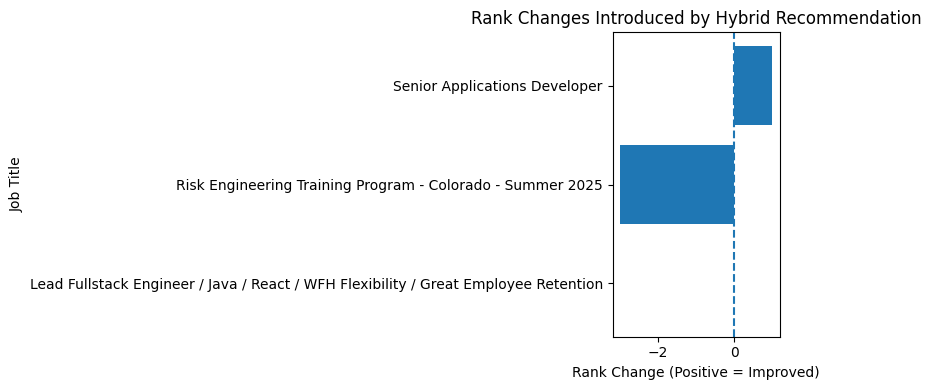

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.barh(
    plot_df["job_title"],
    plot_df["Rank_Change"]
)
plt.axvline(0, linestyle="--")
plt.xlabel("Rank Change (Positive = Improved)")
plt.title("Rank Changes Introduced by Hybrid Recommendation")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()


## Final Model Decision

Multiple recommendation approaches were implemented and evaluated in this project, including TF-IDF, BM25, and Sentence-BERT (SBERT). Each method demonstrated distinct strengths when applied to job recommendation.

TF-IDF and BM25 performed well for keyword-based queries and provided strong baseline performance with high interpretability. However, these approaches relied heavily on exact term overlap and were less effective when user queries and job descriptions used different vocabulary to express similar concepts.

SBERT demonstrated superior semantic understanding by capturing contextual meaning beyond keyword matching. This allowed the system to retrieve relevant job postings even when exact keywords differed, resulting in more semantically aligned recommendations.

Based on qualitative evaluation, similarity score analysis, and ranking behavior, SBERT was selected as the primary content-based recommendation model. To further enhance personalization and robustness, a hybrid recommendation approach was adopted by combining SBERT-based content similarity with a collaborative filtering component.

The final deployed recommendation strategy therefore uses a hybrid model, which balances semantic relevance and collaborative signals to provide more effective and user-centric job recommendations.
